# INF-0616 - Projeto 2: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitor: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  

Nomes:
- Vitor de Oliveira Fernandez Araujo
- Vitor Sancho Cardoso

Instituto de Computação - Unicamp 2025

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# caminho_pasta = '/content/drive/My Drive/Colab/MDC/AULA4/'

# # Verifique se o caminho da pasta existe
# if os.path.exists(caminho_pasta):
#     # Mude o diretório atual para a pasta desejada
#     os.chdir(caminho_pasta)
#     print("Pasta encontrada. Agora você está na pasta:", caminho_pasta)
# else:
#     print("A pasta especificada não existe:", caminho_pasta)

d = pd.read_csv('customer-issues.csv')
display(d.head())


,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
np.random.seed(42)
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    (sns
     .barplot(x=[l[:40] for l in labels], y=counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)

    return labels, counts

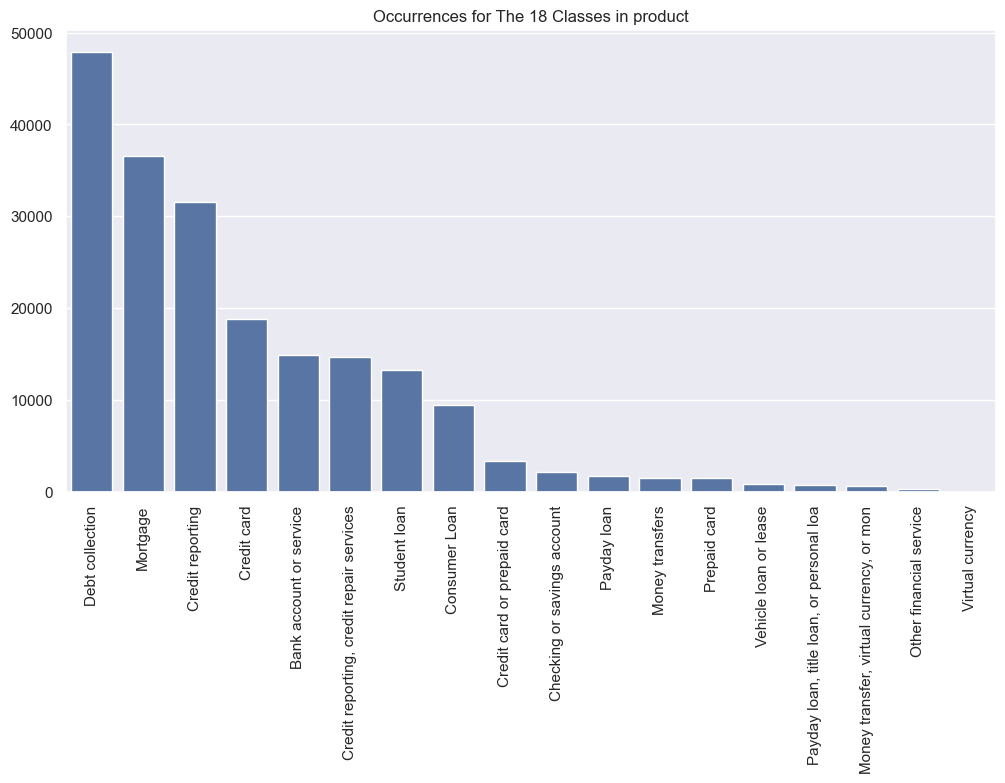

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
np.random.seed(42)
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
np.random.seed(42)

LR = LogisticRegression(
        max_iter=1000,
        random_state=42
    )

grid = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

g = GridSearchCV(
    estimator=LR,
    param_grid=grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True
)
g.fit(x_train, ye_train)


,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.001, 0.01, ...], 'class_weight': [None, 'balanced']}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [11]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print(f'Accuracy: {metrics.accuracy_score(y, p):.3f}')
    print(f'Accuracy (balanced): {metrics.balanced_accuracy_score(y, p):.3f}')

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)

    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))

    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.kdeplot(x = probabilities[y.ravel() == i][:, i],
                    fill = True,
                    label = labels[i] if labels is not None else f'Classe {i}',
                    alpha = 0.4)

    plt.xlabel("Confiança do modelo")
    plt.ylabel("Densidade")
    plt.legend()

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

Accuracy: 0.754
Accuracy (balanced): 0.748


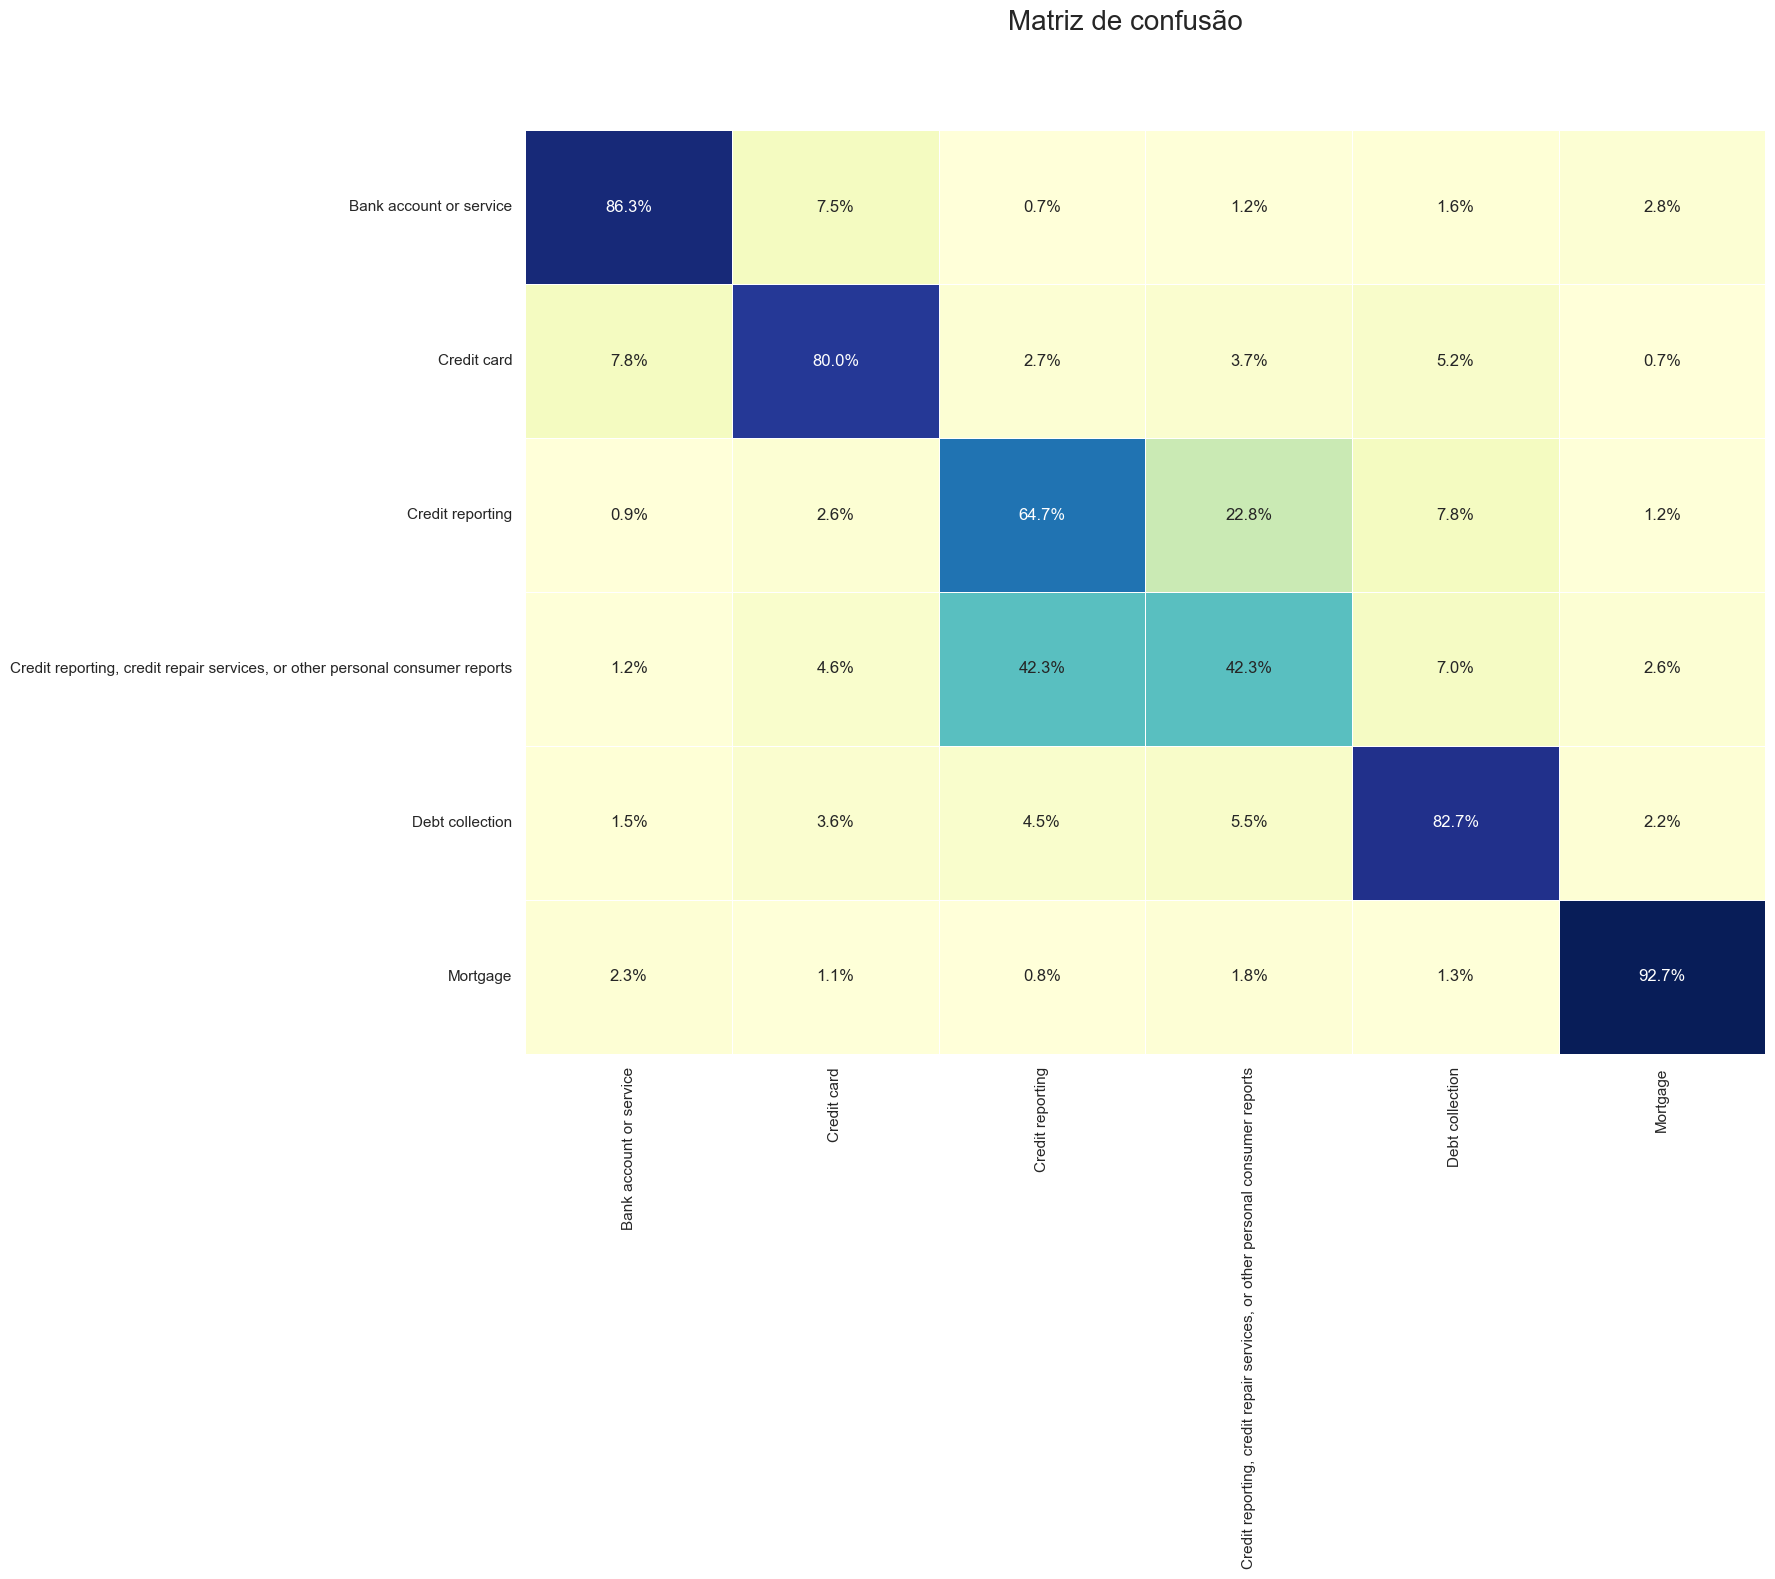

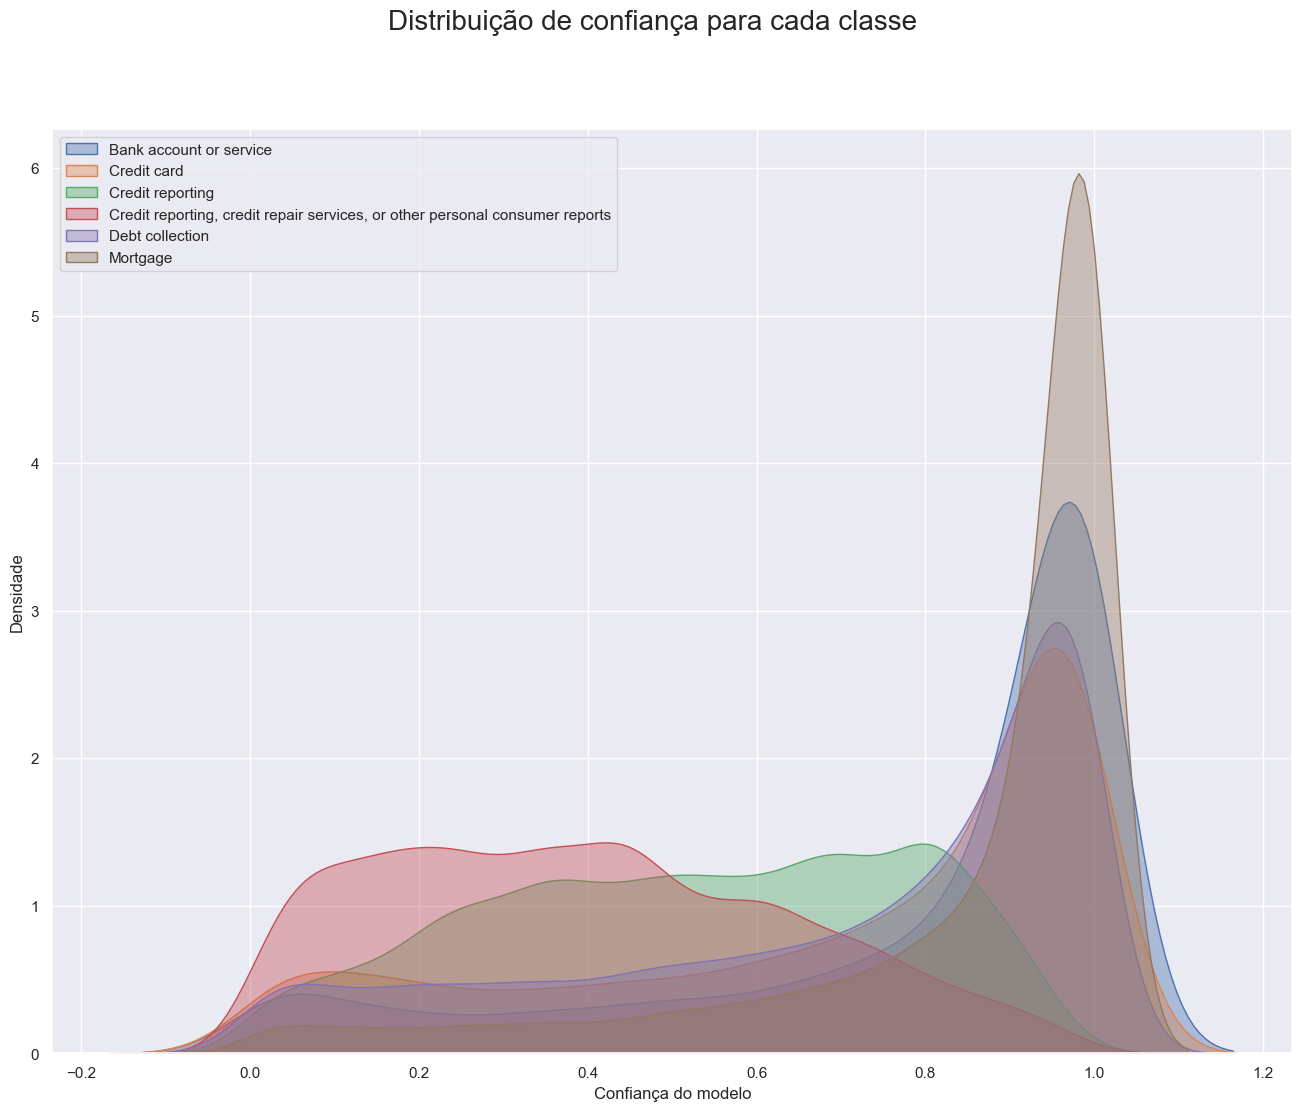

In [12]:
evaluate(ye_test, g.predict(x_test), g.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

A confiança do modelo na maioria das classes é boa, com uma concentração expressiva entre 80% e 100%. No entanto, conseguimos perceber um espalhamento maior da distribuição para as classes "Credit reporting" e "Credit reporting, credit repair services, or other personal consumer reports". Esta diferença também é visível na matriz de confusão, onde é nítida a queda de acurácia entre as duas classes. Essa queda de performance faz sentido, já que os dois temas são ambíguos, tendo a ver com relatórios de crédito. As classes de "Bank account or service" e "Credit card" também apresentam um pouco de ambiguidade entre si, porém em nível muito menor. Este comportamento pode ser visto como um ligeiro aumento na cauda das distribuições de ambas as classes e ao observar as suas respectivas linhas na matriz de confusão (falsos positivos).

----------
----------

## Redes Neurais - Tensorflow
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [13]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from keras import optimizers
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

y_ohe_train = to_categorical(ye_train, num_classes=6)
y_ohe_test = to_categorical(ye_test, num_classes=6)

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)
train_class_weights = dict(enumerate(class_weights))

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema.

In [14]:
model = Sequential([
    Input(shape=(features,)),
    Dense(50, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [15]:
nn_X_train, nn_X_val, nn_y_train, nn_y_val = train_test_split(x_train, y_ohe_train, test_size=0.2, stratify=y_train, random_state=42)
nn_X_test, nn_y_test = x_test, y_ohe_test

In [16]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128


checkpoint = ModelCheckpoint(
    filepath="weights.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6595 - loss: 0.9554
Epoch 1: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7407 - loss: 0.7467 - val_accuracy: 0.7757 - val_loss: 0.6032
Epoch 2/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8076 - loss: 0.5662
Epoch 2: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8088 - loss: 0.5603 - val_accuracy: 0.7828 - val_loss: 0.5898
Epoch 3/20
701/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.4993
Epoch 3: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8297 - loss: 0.4941 - val_accuracy: 0.7897 - val_loss: 0.5824
Epoch 4/20
702/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.4429
Epoch 4: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8476 - loss: 0.4380 - val_accuracy: 0.7984 - val_loss: 0.5814
Epoch 5/20
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8637 - loss: 0.3930
Epoch 5: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8652 - loss: 0.3882 - val_accuracy: 0.8009 - val_loss: 0.5931
Epoch 6/20
711/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8766 - loss: 0.3490
Epoch 6: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8780 - loss: 0.3442 - val_accuracy: 0.8034 - val_loss: 0.6072
Epoch 7/20
696/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8893 - loss: 0.3097
Epoch 7: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8908 - loss: 0.3058 - val_accuracy: 0.8055 - val_loss: 0.6280
Epoch 8/20
700/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8998 - loss: 0.2767
Epoch 8: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.2724 - val_accuracy: 0.8055 - val_loss: 0.6579
Epoch 9/20
705/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9090 - loss: 0.2469
Epoch 9: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9110 - loss: 0.2426 - val_accuracy: 0.8111 - val_loss: 0.6742
Epoch 10/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9197 - loss: 0.2198
Epoch 10: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9213 - loss: 0.2168 - val_accuracy: 0.8098 - val_loss: 0.7094
Epoch 11/20
698/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2002
Epoch 11: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9283 - loss: 0.1959 - val_accuracy: 0.8103 - val_loss: 0.7489
Epoch 12/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 0.1815
Epoch 12: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9352 - loss: 0.1768 - val_accuracy: 0.8118 - val_loss: 0.7768
Epoch 13/20
709/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9415 - loss: 0.1617
Epoch 13: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9427 - loss: 0.1590 - val_accuracy: 0.8105 - val_loss: 0.8220
Epoch 14/20
707/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9478 - loss: 0.1462
Epoch 14: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9485 - loss: 0.1443 - val_accuracy: 0.8089 - val_loss: 0.8541
Epoch 15/20
702/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9526 - loss: 0.1335
Epoch 15: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9539 - loss: 0.1305 - val_accuracy: 0.8104 - val_loss: 0.8898
Epoch 16/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9576 - loss: 0.1199
Epoch 16: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9587 - loss: 0.1176 - val_accuracy: 0.8128 - val_loss: 0.9188
Epoch 17/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9633 - loss: 0.1080
Epoch 17: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9642 - loss: 0.1062 - val_accuracy: 0.8119 - val_loss: 0.9605
Epoch 18/20
712/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9667 - loss: 0.0986
Epoch 18: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9683 - loss: 0.0961 - val_accuracy: 0.8157 - val_loss: 0.9788
Epoch 19/20
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9712 - loss: 0.0890
Epoch 19: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9721 - loss: 0.0875 - val_accuracy: 0.8171 - val_loss: 1.0141
Epoch 20/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0808
Epoch 20: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9753 - loss: 0.0793 - val_accuracy: 0.8164 - val_loss: 1.0538


In [17]:
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

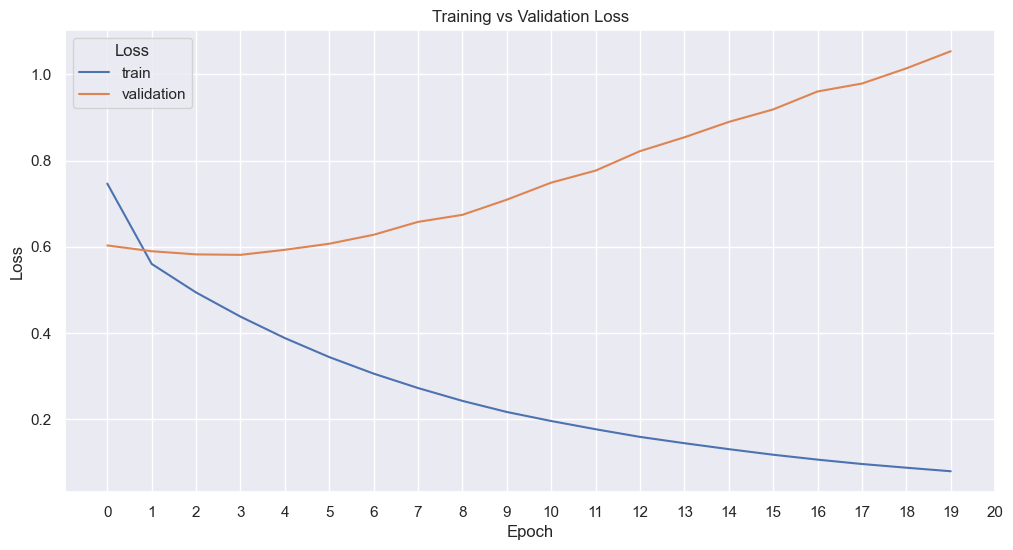

In [18]:
df = pd.DataFrame({
    'epoch': history.epoch,
    'train': history.history['loss'],
    'validation': history.history['val_loss']
})

# Melt to long format
df_melted = df.melt(id_vars='epoch', value_vars=['train', 'validation'],
                    var_name='Loss', value_name='loss')

# Plot
sns.lineplot(data=df_melted, x='epoch', y='loss', hue='Loss')
plt.title('Training vs Validation Loss')
plt.xticks(range(0, epochs+1, 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

A progressão da loss mostrou uma degradação rápida no gráfico, indicando que o modelo ainda não está conseguindo capturar bem a complexidade dos dados. A partir da época 3, o erro de validação já começou a subir de forma consistente, indicando um overfit do modelo, já que o erro de treinamento manteve uma queda constante.

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

In [19]:
y_pred = model.predict(nn_X_test)

1543/1543 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Accuracy: 0.717
Accuracy (balanced): 0.699


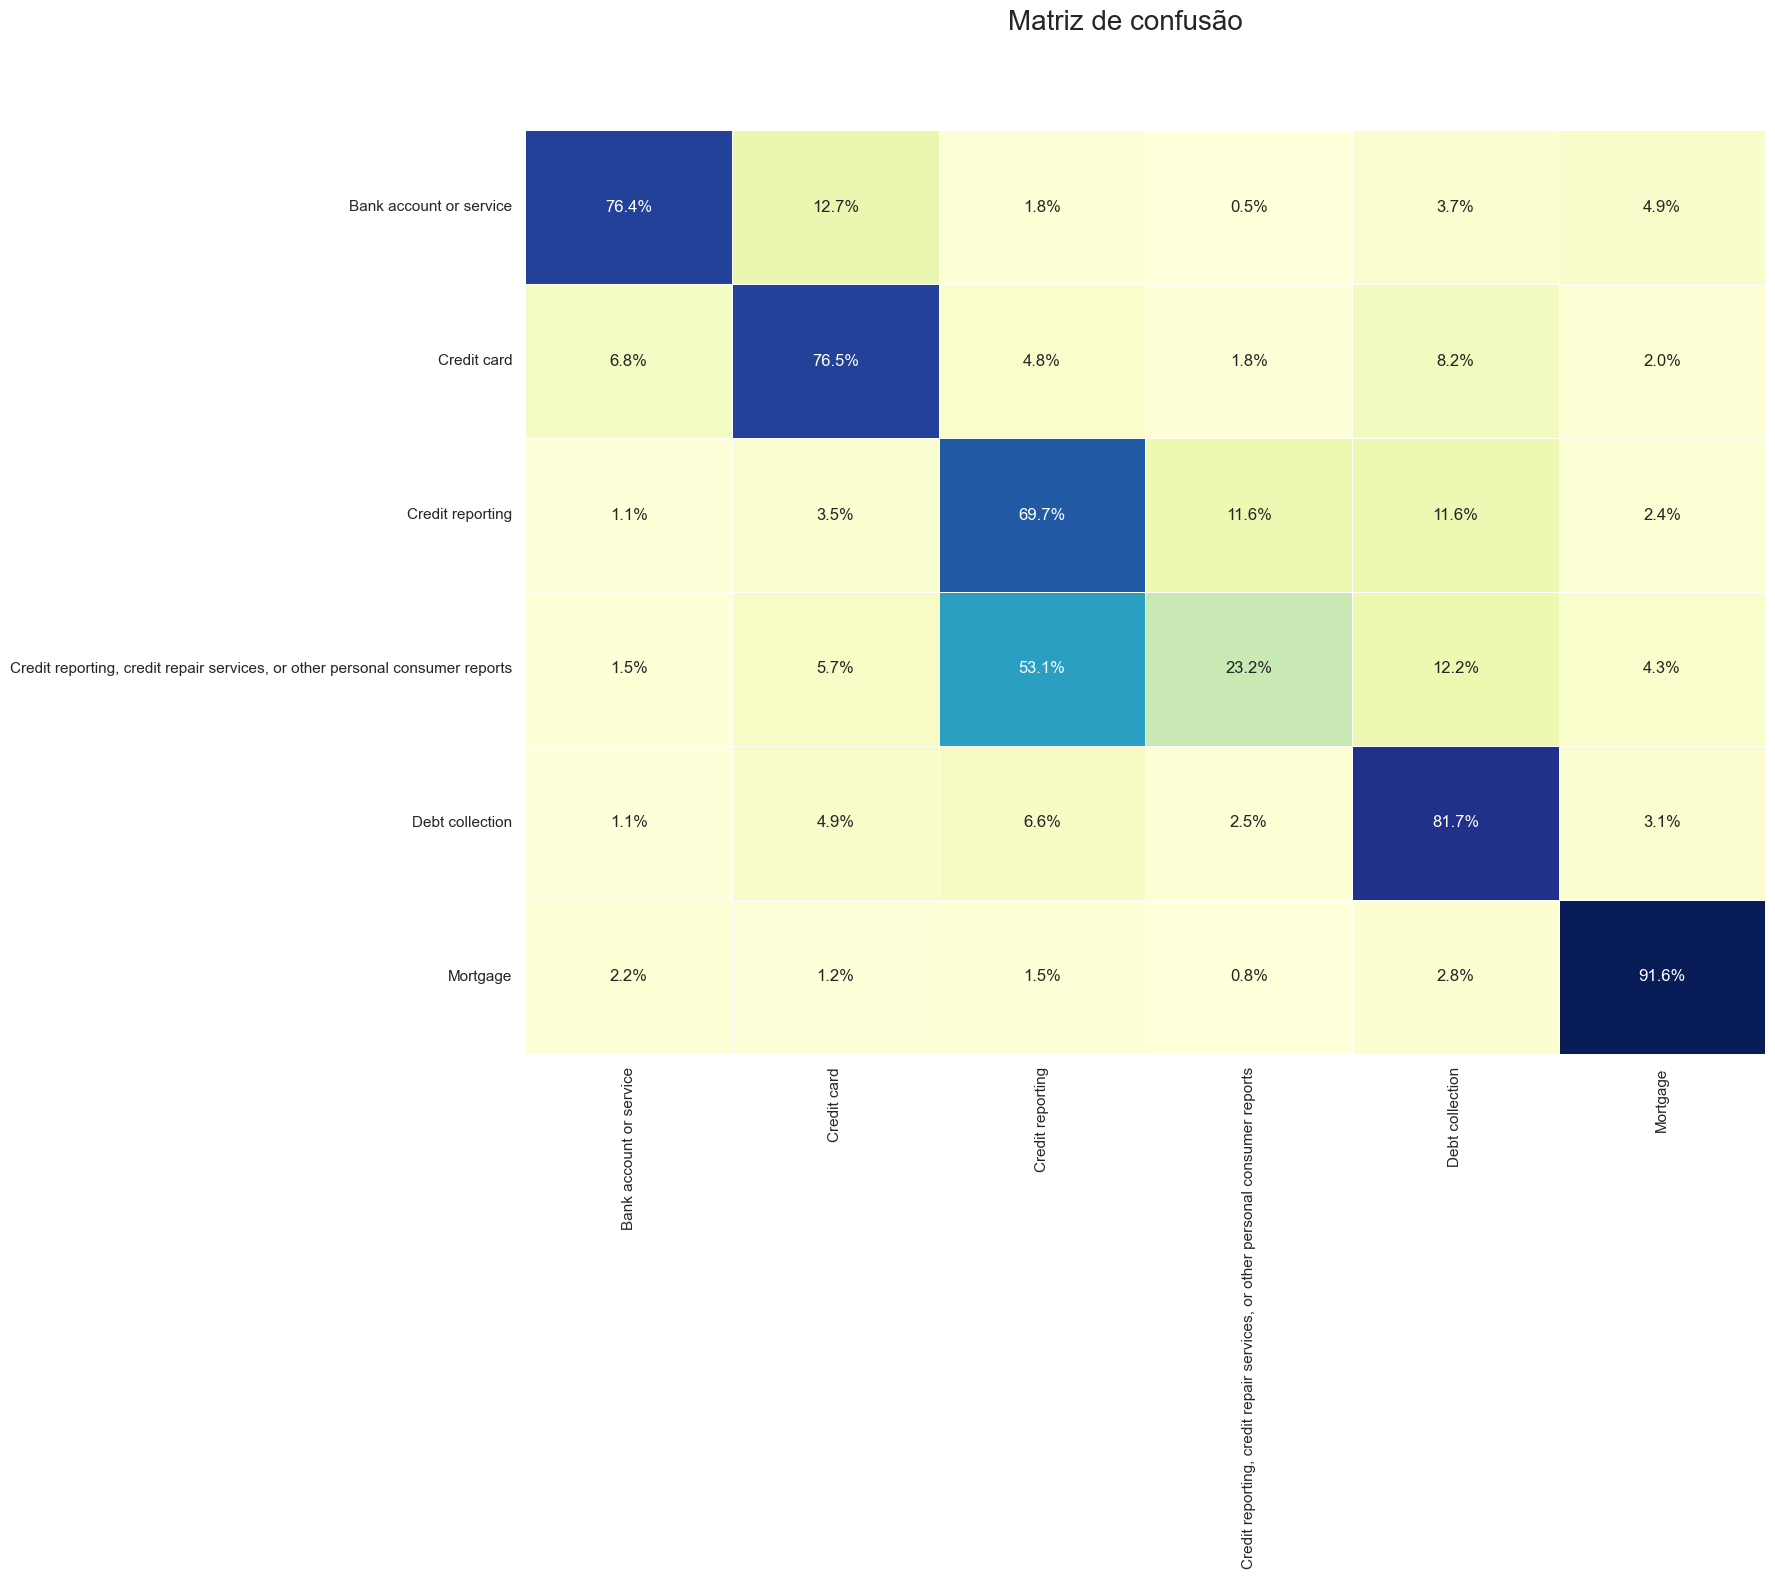

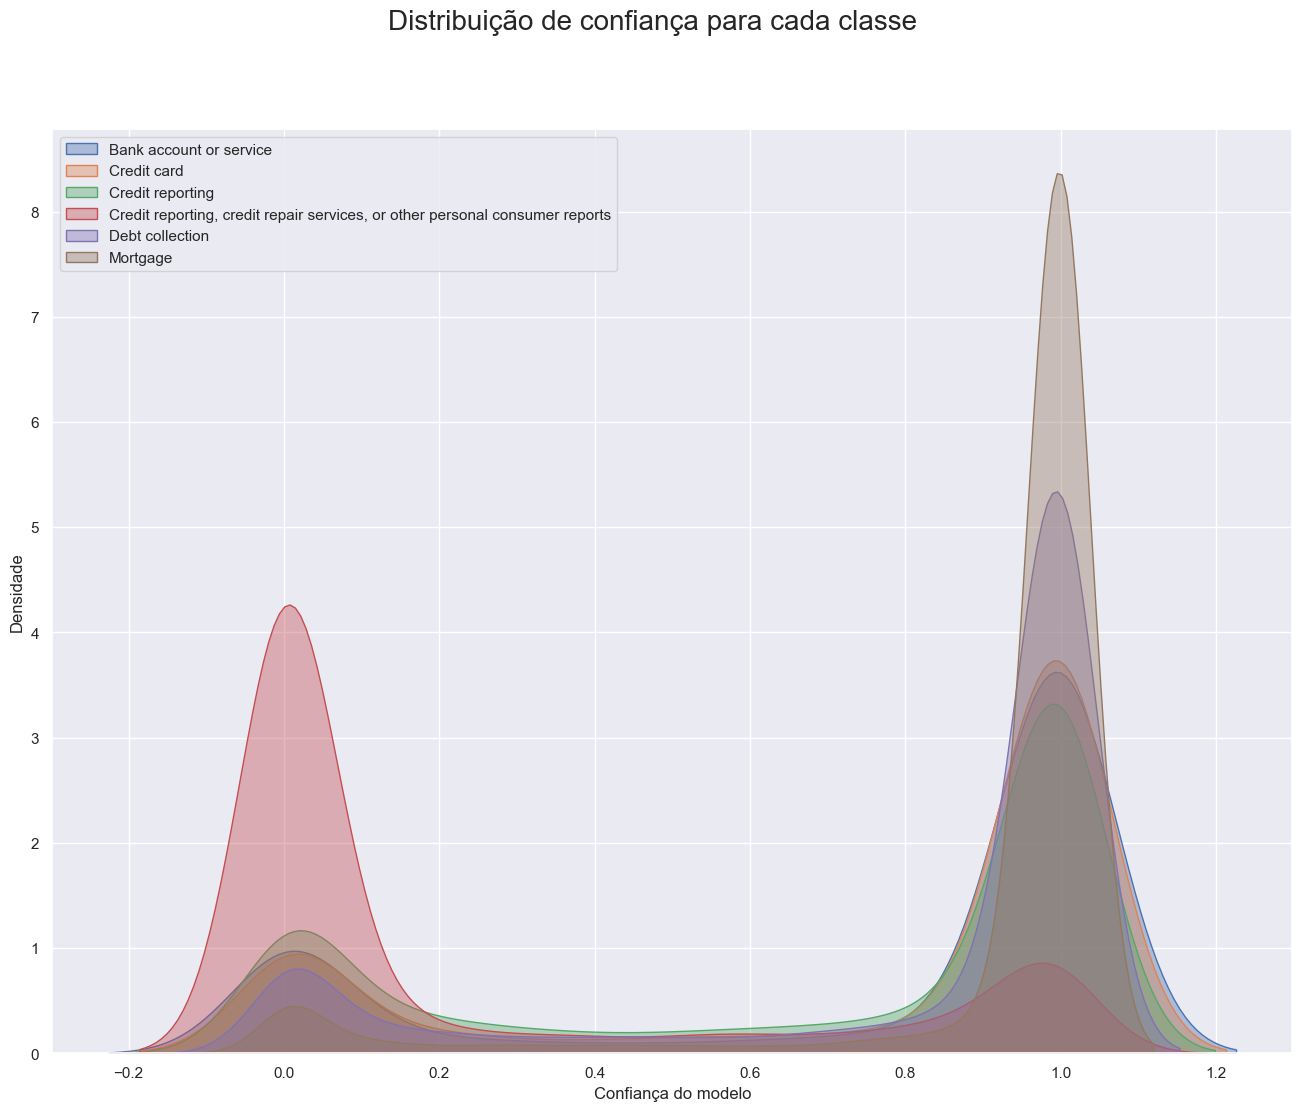

In [20]:
## para poder usar a função, precisei utilizar o dataset ye_test, sem one hot encoding
evaluate(ye_test, np.argmax(y_pred, axis=1), y_pred, labels=label_enc.classes_)

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [21]:
model2 = Sequential([
    Input(shape=(features,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')
])

model2.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Atividade (1 pt):** treine a nova rede.

In [22]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128

earlystop2 = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)


checkpoint2 = ModelCheckpoint(
    filepath="weights2.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


history2 = model2.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[earlystop2, checkpoint2],
)

Epoch 1/20
710/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6130 - loss: 1.0313
Epoch 1: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7207 - loss: 0.7847 - val_accuracy: 0.7714 - val_loss: 0.6064
Epoch 2/20
699/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8013 - loss: 0.5828
Epoch 2: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8045 - loss: 0.5736 - val_accuracy: 0.7974 - val_loss: 0.5702
Epoch 3/20
698/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.5201
Epoch 3: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8235 - loss: 0.5158 - val_accuracy: 0.8050 - val_loss: 0.5600
Epoch 4/20
698/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8363 - loss: 0.4748
Epoch 4: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8361 - loss: 0.4719 - val_accuracy: 0.8127 - val_loss: 0.5532
Epoch 5/20
701/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.4374
Epoch 5: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8489 - loss: 0.4341 - val_accuracy: 0.8141 - val_loss: 0.5639
Epoch 6/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.4051
Epoch 6: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8584 - loss: 0.4029 - val_accuracy: 0.8155 - val_loss: 0.5809
Epoch 7/20
706/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 - loss: 0.3789
Epoch 7: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8654 - loss: 0.3767 - val_accuracy: 0.8132 - val_loss: 0.6046
Epoch 8/20
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8724 - loss: 0.3566
Epoch 8: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8727 - loss: 0.3534 - val_accuracy: 0.8123 - val_loss: 0.6324
Epoch 9/20
710/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8809 - loss: 0.3339
Epoch 9: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8791 - loss: 0.3354 - val_accuracy: 0.8135 - val_loss: 0.6523
Epoch 10/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.3231
Epoch 10: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8813 - loss: 0.3231 - val_accuracy: 0.8150 - val_loss: 0.6575
Epoch 11/20
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8865 - loss: 0.3070
Epoch 11: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8862 - loss: 0.3083 - val_accuracy: 0.8101 - val_loss: 0.6924
Epoch 12/20
698/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8895 - loss: 0.2971
Epoch 12: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8891 - loss: 0.2969 - val_accuracy: 0.8077 - val_loss: 0.7195
Epoch 13/20
707/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8933 - loss: 0.2880
Epoch 13: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8936 - loss: 0.2862 - val_accuracy: 0.8043 - val_loss: 0.7485
Epoch 14/20
702/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8952 - loss: 0.2780
Epoch 14: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8961 - loss: 0.2772 - val_accuracy: 0.8130 - val_loss: 0.7509
Epoch 15/20
696/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9009 - loss: 0.2661
Epoch 15: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8995 - loss: 0.2672 - val_accuracy: 0.8140 - val_loss: 0.7685
Epoch 16/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9025 - loss: 0.2583
Epoch 16: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9027 - loss: 0.2578 - val_accuracy: 0.8105 - val_loss: 0.7910


**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

model3 = Sequential([
    Input(shape=(features,)),
    # input já sofreu StandardScaling
    Dense(32, activation='relu'),
    BatchNormalization(momentum=0.8),
    Dense(32, activation='relu'),
    BatchNormalization(momentum=0.8),
    Dense(6, activation='softmax')
])

model3.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.8),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

epochs = 20
batch_size = 128

earlystop3 = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True
)

checkpoint3 = ModelCheckpoint(
    filepath="weights3.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


history3 = model3.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[earlystop3, checkpoint3],
)

Epoch 1/20
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5824 - loss: 1.3347
Epoch 1: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6925 - loss: 1.1035 - val_accuracy: 0.7609 - val_loss: 0.9183
Epoch 2/20
710/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7890 - loss: 0.9059
Epoch 2: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7953 - loss: 0.8958 - val_accuracy: 0.7818 - val_loss: 0.8815
Epoch 3/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8137 - loss: 0.8572
Epoch 3: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8156 - loss: 0.8522 - val_accuracy: 0.7930 - val_loss: 0.8658
Epoch 4/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 0.8266
Epoch 4: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8291 - loss: 0.8227 - val_accuracy: 0.8006 - val_loss: 0.8560
Epoch 5/20
705/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.8017
Epoch 5: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8386 - loss: 0.7985 - val_accuracy: 0.8061 - val_loss: 0.8498
Epoch 6/20
712/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.7804
Epoch 6: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8473 - loss: 0.7777 - val_accuracy: 0.8099 - val_loss: 0.8449
Epoch 7/20
712/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8550 - loss: 0.7619
Epoch 7: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8556 - loss: 0.7594 - val_accuracy: 0.8127 - val_loss: 0.8434
Epoch 8/20
704/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8623 - loss: 0.7461
Epoch 8: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8620 - loss: 0.7441 - val_accuracy: 0.8148 - val_loss: 0.8429
Epoch 9/20
703/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.7328
Epoch 9: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8676 - loss: 0.7307 - val_accuracy: 0.8164 - val_loss: 0.8439
Epoch 10/20
704/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8730 - loss: 0.7206
Epoch 10: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8729 - loss: 0.7189 - val_accuracy: 0.8166 - val_loss: 0.8462
Epoch 11/20
703/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8775 - loss: 0.7100
Epoch 11: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8778 - loss: 0.7079 - val_accuracy: 0.8190 - val_loss: 0.8469
Epoch 12/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8819 - loss: 0.7006
Epoch 12: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8821 - loss: 0.6986 - val_accuracy: 0.8189 - val_loss: 0.8505
Epoch 13/20
699/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8869 - loss: 0.6919
Epoch 13: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8866 - loss: 0.6901 - val_accuracy: 0.8195 - val_loss: 0.8526
Epoch 14/20
712/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.6843
Epoch 14: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8906 - loss: 0.6825 - val_accuracy: 0.8201 - val_loss: 0.8548
Epoch 15/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8942 - loss: 0.6775
Epoch 15: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8936 - loss: 0.6760 - val_accuracy: 0.8198 - val_loss: 0.8578
Epoch 16/20
697/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8972 - loss: 0.6715
Epoch 16: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8965 - loss: 0.6699 - val_accuracy: 0.8221 - val_loss: 0.8585
Epoch 17/20
700/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8996 - loss: 0.6658
Epoch 17: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.6644 - val_accuracy: 0.8222 - val_loss: 0.8599
Epoch 18/20
711/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9018 - loss: 0.6614
Epoch 18: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9007 - loss: 0.6601 - val_accuracy: 0.8212 - val_loss: 0.8637
Epoch 19/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9037 - loss: 0.6571
Epoch 19: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9030 - loss: 0.6560 - val_accuracy: 0.8212 - val_loss: 0.8653
Epoch 20/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9056 - loss: 0.6532
Epoch 20: saving model to weights3.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9053 - loss: 0.6518 - val_accuracy: 0.8204 - val_loss: 0.8680


**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

In [24]:
y_pred2 = model2.predict(nn_X_test)
y_pred3 = model3.predict(nn_X_test)

1543/1543 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Curiosamente, o primeiro modelo testado, muito mais simples, se mostrou muito superior a todos os outros, mesmo após algumas tentativas de regularização e mudanças em outros hiperparâmetros. O primeiro modelo de rede neural, com apenas uma hidden layer de 50 unidades, conseguiu atingir uma acurácia de 72%, enquanto os outros foram muito piores. Tentamos investigar motivos, mas em todos os treinamentos dos modelos seguintes, o comportamento do loss sempre foi ascendente na validação, mostrando grande dificuldade de aprendizado nos modelos.

In [25]:
print(metrics.classification_report(ye_test, np.argmax(y_pred, axis=1), target_names=label_enc.classes_))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.77      0.76      0.77      4058
                                                                 Credit card       0.65      0.76      0.70      4902
                                                            Credit reporting       0.53      0.70      0.60      8604
Credit reporting, credit repair services, or other personal consumer reports       0.53      0.23      0.32      7620
                                                             Debt collection       0.80      0.82      0.81     13884
                                                                    Mortgage       0.88      0.92      0.90     10279

                                                                    accuracy                           0.72     49347
                                                      

In [26]:

print(metrics.classification_report(ye_test, np.argmax(y_pred2, axis=1), target_names=label_enc.classes_))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.75      0.83      0.79      4058
                                                                 Credit card       0.67      0.80      0.73      4902
                                                            Credit reporting       0.55      0.69      0.61      8604
Credit reporting, credit repair services, or other personal consumer reports       0.52      0.30      0.38      7620
                                                             Debt collection       0.85      0.81      0.83     13884
                                                                    Mortgage       0.90      0.94      0.92     10279

                                                                    accuracy                           0.74     49347
                                                      

In [27]:
print(metrics.classification_report(ye_test, np.argmax(y_pred3, axis=1), target_names=label_enc.classes_))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.79      0.82      0.80      4058
                                                                 Credit card       0.69      0.80      0.74      4902
                                                            Credit reporting       0.54      0.69      0.61      8604
Credit reporting, credit repair services, or other personal consumer reports       0.51      0.28      0.36      7620
                                                             Debt collection       0.84      0.84      0.84     13884
                                                                    Mortgage       0.91      0.93      0.92     10279

                                                                    accuracy                           0.74     49347
                                                      